# Titanic - Machine Learning from Disaster

Neural network model for classifying survivors from Titanic sinkage.

Data is available at [Kaggle Titanic competition](https://www.kaggle.com/competitions/titanic/).


In [81]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

## Loading data


In [82]:
train_input = pd.read_csv("./data/train.csv")
test_input = pd.read_csv("./data/test.csv")

train_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [83]:
test_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Split the data into features and targets


In [84]:
features_train = train_input.iloc[:, 2:]
targets_train = train_input["Survived"]

In [85]:
data_test = test_input.iloc[:, 1:]

Create validation set for later


In [86]:
data_train, data_val, labels_train, labels_val = train_test_split(
    features_train,
    targets_train,
    test_size=0.2,
    stratify=targets_train,
)

## Preprocessing


In [87]:
data_train.head(10)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
534,3,"Cacic, Miss. Marija",female,30.0,0,0,315084,8.6625,NaN,S
414,3,"Sundman, Mr. Johan Julian",male,44.0,0,0,STON/O 2. 3101269,7.9250,NaN,S
448,3,"Baclini, Miss. Marie Catherine",female,5.0,2,1,2666,19.2583,NaN,C
251,3,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",female,29.0,1,1,347054,10.4625,G6,S
188,3,"Bourke, Mr. John",male,40.0,1,1,364849,15.5000,NaN,Q
324,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.5500,NaN,S
848,2,"Harper, Rev. John",male,28.0,0,1,248727,33.0000,NaN,S
184,3,"Kink-Heilmann, Miss. Luise Gretchen",female,4.0,0,2,315153,22.0250,NaN,S
293,3,"Haas, Miss. Aloisia",female,24.0,0,0,349236,8.8500,NaN,S
856,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S


In [88]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 534 to 671
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Name      712 non-null    object 
 2   Sex       712 non-null    object 
 3   Age       573 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Ticket    712 non-null    object 
 7   Fare      712 non-null    float64
 8   Cabin     165 non-null    object 
 9   Embarked  711 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 61.2+ KB


In [89]:
data_train.nunique()

Pclass        3
Name        712
Sex           2
Age          84
SibSp         7
Parch         7
Ticket      560
Fare        228
Cabin       126
Embarked      3
dtype: int64

Name, Ticket and Cabin are too distinct.


In [90]:
data_train.describe()

,Pclass,Age,SibSp,Parch,Fare
count,712.000000,573.000000,712.000000,712.000000,712.000000
mean,2.307584,29.358063,0.542135,0.387640,33.051749
std,0.839964,14.223443,1.153930,0.822513,51.718505
min,1.000000,0.670000,0.000000,0.000000,0.000000
25%,2.000000,20.000000,0.000000,0.000000,7.925000
50%,3.000000,28.000000,0.000000,0.000000,14.458300
75%,3.000000,38.000000,1.000000,0.000000,31.275000
max,3.000000,80.000000,8.000000,6.000000,512.329200


Some columns have missing values and their ranges vary a lot. There are also categorical features present.


### Pipelines


For numerical features fill the missing values with means, then scale them to range between 0 and 1.


In [91]:
numerical_pipeline = Pipeline(
    [
        ("impute", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("scale", MinMaxScaler(feature_range=(0, 1))),
    ]
)

For categorical features fill the missing values with the most common value, then one-hot encode them.


In [92]:
categorical_pipeline = Pipeline(
    [
        ("impute", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
        ("encode", OneHotEncoder(sparse_output=False)),
        ("scale", MinMaxScaler(feature_range=(0, 1))),
    ]
)

Combine them into a single pipeline which will work on input DataFrames.


In [93]:
numerical_features = ["Age", "SibSp", "Parch", "Fare"]
categorical_features = ["Pclass", "Sex", "Embarked"]

data_preprocessing = ColumnTransformer(
    [
        ("numerical_pipeline", numerical_pipeline, numerical_features),
        ("categorical_pipeline", categorical_pipeline, categorical_features),
    ]
)

In [94]:
data_train_processed = data_preprocessing.fit_transform(data_train)
data_val_processed = data_preprocessing.fit_transform(data_val)
pd.DataFrame(data_train_processed).describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.361629,0.067767,0.064607,0.064513,0.245787,0.200843,0.553371,0.366573,0.633427,0.188202,0.080056,0.731742
std,0.160816,0.144241,0.137086,0.100948,0.430855,0.400912,0.497493,0.482207,0.482207,0.391148,0.271571,0.443364
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.268877,0.000000,0.000000,0.015469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.361629,0.000000,0.000000,0.028221,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.432749,0.125000,0.000000,0.061045,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Defining and training the model


### Model definition


Define a partial to make the code less cluttered.


In [95]:
base_dense = partial(
    tf.keras.layers.Dense,
    activation="relu",
    kernel_initializer="he_uniform",
)

Now define the model.


In [96]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(data_train_processed.shape[-1],)),
        base_dense(512),
        base_dense(512),
        base_dense(1024),
        base_dense(1024),
        base_dense(1024),
        base_dense(512),
        base_dense(512),
        base_dense(1, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_101 (Dense)               │ (None, 512)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,681,793 (14.04 MB)

 Trainable params: 3,681,793 (14.04 MB)

 Non-trainable params: 0 (0.00 B)

### Training


In [97]:
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.9, nesterov=True)
loss = tf.keras.losses.BinaryCrossentropy()

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"],
)

In [98]:
n_epochs = 1000

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=48, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", patience=16, factor=0.01, min_lr=1e-5
    ),
]

hist = model.fit(
    data_train_processed,
    labels_train,
    epochs=n_epochs,
    validation_data=(data_val_processed, labels_val),
    callbacks=callbacks,
)

Epoch 1/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.6898 - loss: 0.5777 - val_accuracy: 0.7821 - val_loss: 0.4660 - learning_rate: 0.0100
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8098 - loss: 0.4324 - val_accuracy: 0.8212 - val_loss: 0.4107 - learning_rate: 0.0100
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8102 - loss: 0.4288 - val_accuracy: 0.7933 - val_loss: 0.4679 - learning_rate: 0.0100
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7895 - loss: 0.4719 - val_accuracy: 0.8045 - val_loss: 0.4254 - learning_rate: 0.0100
Epoch 5/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8302 - loss: 0.4298 - val_accuracy: 0.7877 - val_loss: 0.4859 - learning_rate: 0.0100
Epoch 6/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8003 - loss: 0.4638 - val_accuracy: 0.8268 - val_loss: 0.3986 - learning_rate: 0.0100
Epoch 7/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8258 - loss: 0.4234 

### Explore the result


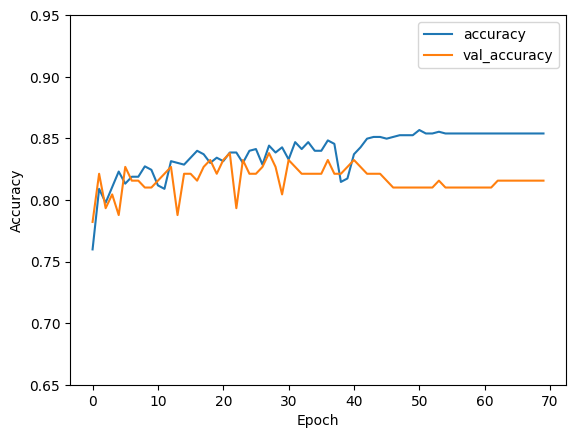

In [99]:
pd.DataFrame(
    {
        "accuracy": hist.history["accuracy"],
        "val_accuracy": hist.history["val_accuracy"],
    }
).plot()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.65, 0.95)
plt.show()

Validation accuracy is very close to the actual accuracy.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88       131
         1.0       0.64      0.92      0.75        48

    accuracy                           0.84       179
   macro avg       0.80      0.86      0.82       179
weighted avg       0.88      0.84      0.85       179



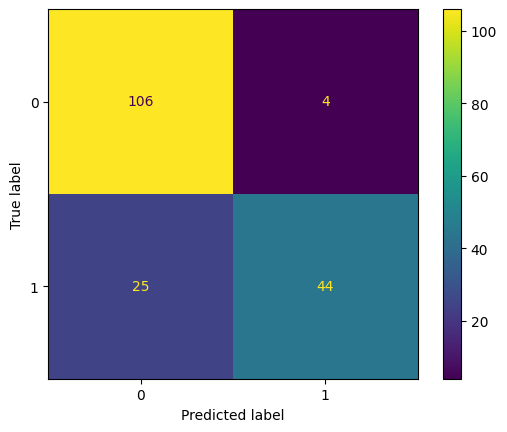

In [101]:
predictions_val = model.predict(data_val_processed)
predictions_val[predictions_val >= 0.5] = 1
predictions_val[predictions_val < 0.5] = 0

print(classification_report(predictions_val, labels_val))
ConfusionMatrixDisplay.from_predictions(labels_val, predictions_val)

### Predicting values


In [103]:
data_test_processed = data_preprocessing.fit_transform(data_test)
predictions = model.predict(data_test_processed)
predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0
predictions.shape

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


(418, 1)

Save the prediction to csv for contest entry.


In [104]:
predictions_df = pd.DataFrame(
    {
        "PassengerId": test_input["PassengerId"],
        "Survived": predictions.reshape(-1),
    }
)

# change stubborn Survived to int
predictions_df = predictions_df.astype(
    dtype={
        "PassengerId": "object",
        "Survived": "int64",
    }
)

predictions_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [105]:
predictions_df.to_csv("result.csv", index=False)

0.779% accuracy on Kaggle.
